In [1]:
from pathlib import Path
import pandas as pd


test_data_path = Path("../data/interim/test.csv")
test_df = pd.read_csv(test_data_path)

In [2]:
from pathlib import Path
from joblib import load


encoder = load(Path("../model/encoder.joblib"))

モデルを読み込みます。

In [3]:
model = load(Path("../model/model.joblib")) 
other_model = load(Path("../model/other_model.joblib"))  

評価では何度も予測を行うため、予測を行うための関数を準備しておきます。

In [4]:
def predict(test_df, model, prediction_name="SalePricePredicted"):
    preprocessed = encoder.transform(test_df)
    preprocessed_df = pd.DataFrame(preprocessed, columns=test_df.columns)
    preprocessed_df = preprocessed_df.fillna(preprocessed_df.median())
    
    X = preprocessed_df.drop("SalePrice", axis=1)
    y = preprocessed_df["SalePrice"]

    prediction = model.predict(X)
    
    # 予測されるのは標準化された予測値なので、元に戻す
    inversed_y = encoder.named_transformers_["standardscaler-2"].inverse_transform(prediction.reshape((-1, 1)))
    
    prediction_df = pd.concat([
        test_df, pd.DataFrame(inversed_y, columns=[prediction_name]),
    ], axis=1)

    return prediction_df

関数を使い、予測を行ってみます。

In [5]:
prediction_df = predict(test_df, model)
prediction_df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities,SalePricePredicted
0,1381,30,45.0,8212,3,3,1914,1950,0.0,203,...,None,Edwards,Y,CompShg,Gable,Normal,WD,Pave,AllPub,123890.435783
1,596,20,69.0,11302,8,5,2005,2006,238.0,1422,...,BrkFace,StoneBr,Y,CompShg,Gable,Partial,New,Pave,AllPub,242759.443804
2,300,20,80.0,14000,6,8,1950,2004,0.0,0,...,None,Crawfor,Y,CompShg,Gable,Family,WD,Pave,AllPub,163357.713781
3,1087,160,NaN,1974,4,5,1973,1973,0.0,334,...,None,MeadowV,Y,CompShg,Gable,Normal,WD,Pave,AllPub,128276.882677
4,390,60,96.0,12474,10,5,2007,2008,272.0,1280,...,Stone,NridgHt,Y,CompShg,Gable,Partial,New,Pave,AllPub,262949.454219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,781,20,63.0,7875,7,5,1995,1996,38.0,0,...,BrkFace,Gilbert,Y,CompShg,Gable,Normal,WD,Pave,AllPub,178362.010895
434,847,60,75.0,9317,7,5,1993,1993,137.0,513,...,BrkFace,SawyerW,Y,CompShg,Gable,Normal,WD,Pave,AllPub,201556.181796
435,32,20,NaN,8544,5,6,1966,2006,0.0,0,...,None,Sawyer,Y,CompShg,Gable,Normal,WD,Pave,AllPub,167649.230206
436,548,85,54.0,7244,5,7,1970,1970,0.0,619,...,None,Mitchel,Y,CompShg,Gable,Normal,WD,Pave,AllPub,164301.220745


モデルの性能を計測しましょう。`squared=False`にすることで平方根を取ったRMSEが得られます。

In [6]:
from sklearn.metrics import mean_squared_error


rmse = mean_squared_error(prediction_df["SalePrice"], prediction_df["SalePricePredicted"], squared=False)
print(f"Mean squared error is {rmse}")

Mean squared error is 51108.524838175435


5万ドルの差異は小さくないように思えます。[決定係数](https://ja.wikipedia.org/wiki/%E6%B1%BA%E5%AE%9A%E4%BF%82%E6%95%B0)は、予測対象のデータをどれだけモデルで説明できたかを表す0~1の指標です。決定係数も算出してみましょう。

In [7]:
from sklearn.metrics import r2_score


r2 = r2_score(prediction_df["SalePrice"], prediction_df["SalePricePredicted"])
print(f"R2 score is {r2}")

R2 score is 0.5589774144900751


決定係数を見ても、まだ改善の余地はありそうです。

予測の分布を比較してみると、元のデータの分布より高めに予測されていることがわかります。

<AxesSubplot:ylabel='Frequency'>

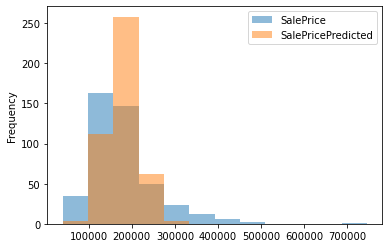

In [8]:
pd.concat([prediction_df["SalePrice"], prediction_df["SalePricePredicted"]], axis=1).plot.hist(bins=12, alpha=0.5)

*Exercise: もう片方のモデルでも性能を計測してみましょう*

In [9]:
prediction_other_df = predict(test_df, other_model)
rmse = mean_squared_error(prediction_other_df["SalePrice"], prediction_other_df["SalePricePredicted"], squared=False)
r2 = r2_score(prediction_other_df["SalePrice"], prediction_other_df["SalePricePredicted"])
print(f"Mean squared error is {rmse}")
print(f"R2 score is {r2}")

Mean squared error is 28514.857881531683
R2 score is 0.8627170629772308


<AxesSubplot:ylabel='Frequency'>

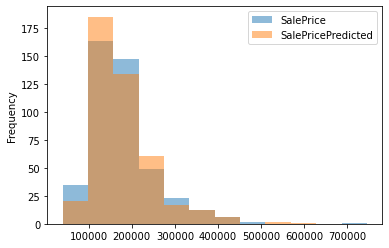

In [10]:
pd.concat([prediction_other_df["SalePrice"], prediction_other_df["SalePricePredicted"]], axis=1).plot.hist(bins=12, alpha=0.5)

元の価格の分布を正確に予測できていることがわかります。

ただ、モデルの性能として「決定係数が0.86でした」といってもプロダクトマネージャーやドメインエキスパートの方は良いのかどうか判断できません。判断するには、モデルレベルより上位のサービス、システムレベルでのテストが必要になります。決定係数が0.8を超えていれば役立つと一度わかれば、モデルレベルで決定係数0.8を維持するという目安がモデルのリリース可否判断につかえるようになるでしょう。

### コミュニケーション演習

プログラミング演習でモデルの性能を評価しました。性能の妥当性を確認するために、誰に何を依頼すべきでしょうか。

ロールの種別

| 英語名             | 日本語名                   | 役割                                                                 |
|--------------------|----------------------------|----------------------------------------------------------------------|
| Product Manager    | プロダクトマネージャー     | ユーザー体験を向上させるために実装すべきソフトウェア機能を定義する。 |
| Business Analyst   | ビジネスアナリスト         | 解決すべきビジネス上の問題を定義する                                 |
| Data Analyst       | データアナリスト           | データの可視化と分析で問題を定量的に特定する。                       |
| Architect          | アーキテクト               | ソフトウェアアーキテクチャ全体を設計する。                           |
| DevOps Engineer    | DevOpsエンジニア           | ソフトウェアの開発・運用プロセスを自動化する。                       |
| Software Engineer  | ソフトウェアエンジニア     | ソフトウェアの開発を行う。                                           |
| Operator           | 業務担当者                 | ソフトウェアを利用し業務を行う。                                     |
| System Admin       | システム管理者             | サービスの挙動を監視する。                                           |
| IT Auditor         | IT監督者                   | システムや会社全体の権限管理や監査を行う。                           |
| Data architect     | データアーキテクト         | データを管理する基盤を設計、運用する。                               |
| Domain Expert      | 業務有識者                 | 深い業務知識を持ちデータの意味やあるべき状態について定義する。       |
| Data Engineer      | データエンジニア           | 機械学習モデルに入力可能なデータと特徴を作成する。                   |
| Data Scientist     | データサイエンティスト     | 機械学習モデルを開発する。                                           |
| ML Engineer        | 機械学習エンジニア         | 機械学習モデルを本番環境にデプロイ可能な形式に変換する。             |
| ML Operator        | 業務担当者(機械学習側)     | 推論結果に基づき業務を行いつつ、フィードバックを与える。             |
| Model risk Manager | 機械学習モデルリスク管理者 | 機械学習モデルの推論の挙動を監視する。                               |
| MLOps Engineer     | MLOpsエンジニア            | 機械学習モデルの開発・運用プロセスを自動化する。                     |
| AI/ML Architect    | AI/MLアーキテクト          | 機械学習モデル開発に必要なアーキテクチャ全体を設計する。             |

依頼の種別

* 情報共有: 開発に必要な情報/ドキュメントの提供を依頼する
* 作業: 開発に必要な作業を分担(依頼)する
* レビュー: 作業の確度を上げるため/承認を得るためレビューを依頼する


#### DevOpsチームへの依頼例

DevOps EngineerやArchitectに対して次の依頼をするとよいでしょう。

* 作業依頼
   * Environment Setupで取り決めた環境構築手順書に沿ったうえで、機械学習モデルのサービス化を依頼する。
   * サービスレベルでのテストへの協力

#### ビジネスチームへの依頼例

Domain ExpertやProduct Managerに次の確認をするとよいでしょう。

* レビュー(Product Manager)
   * システムレベルでの評価。機械学習モデルを組み込んだ機能のユーザーテスト。
* レビュー(Domain Expert)
   * 業務的な知見からの、機械学習モデルの挙動に対するフィードバック。

#### システム管理チームへの依頼例

Model risk Managerに対して次の依頼をするとよいでしょう。

* レビュー
   * 機械学習を組み込んだシステムとしての法的適合性。
   * システムの振る舞いに対する社会的影響の評価。

## Next Step

[おわりに](../docs/ending.md)

## References

1. 佐藤直人, 小川秀人, 來間啓伸 and 明神智之. [AIソフトウェアのテスト](https://www.amazon.co.jp/dp/B095W5VGB3/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1). 2021.
2. [QA4AI](https://www.qa4ai.jp/)
